<a href="https://colab.research.google.com/github/zlatko2024/Text-Classification-Comparison/blob/main/zlatko_radovanovic_2022_0518_tema2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **UVOD:**

>**Kontekst i ciljevi projekta:**
>>***Tema:*** Komparativna analiza performansi klasincog masinskog ucenja, Zero-shot i Few-shot pristupa u klasifikaciji sentimenta tekstualnih podataka.

>>***Predmet:*** Evaluacija različitih NLP metodologija na bazi Twitter (X) podataka radi utvrdjivanja preciznosti savremenih LLM pristupa u poredjenju sa tradicionalnim modelima.

>>***Svrha:*** Istrazivanje kapaciteta generativnih modela (LLM) da kroz tehnike promptovanja nadmase specificno trenirane ML modele uz koriscenje minimalne kolicine oznacenih podataka.

>**Podaci i izvor informacija:**
Istrazivanje koristi Twitter Sentiment Analysis skup podataka preuzet sa platforme Kaggle.

>>***Izvorni fajl:*** twitter_training.csv.

>>***Opis varijabli:*** Fokus je isključivo na tekstualnom sadržaju poruka (nezavisna varijabla) i pridruzenom sentimentu (ciljna varijabla).

>>***Klasifikacioni prostor:*** Podaci su kategorisani u cetiri klase: Positive, Negative, Neutral i Irrelevant.

>**METODOLOSKI OKVIR:**
>>U radu se primenjuju tri distinktne metodologije kako bi se obuhvatio razvoj NLP tehnologija:
>>>***Klasicno masinsko ucenje (Supervised Learning):***
Transformacija teksta: Primena TF-IDF (Term Frequency-Inverse Document Frequency) tehnike za prevodjenje teksta u numericke vektore.

>>>***Klasifikacioni algoritam:*** Koriscenje Support Vector Machine (SVM) modela kao visokoperformansnog resenja za klasifikaciju teksta.

>>>***Zero-shot klasifikacija (LLM):***
Okvir: Implementacija pomocu LangChain biblioteke.

>>>***Pristup:*** Klasifikacija zasnovana na promptovanju izabranog LLM modela bez dostavljanja prethodnih primera (shots).

>>>***Few-shot klasifikacija (LLM):***
Tehnika: Prosirivanje bazicnog prompta uvodjenjem 3–5 pazljivo selektovanih primera po klasi.

>>>***Cilj:*** Poboljsanje kontekstualnog razumevanja i preciznosti modela kroz ucenje u kontekstu (In-Context Learning).

>>>***Evaluacioni metricki sistem:***

>>>>Za poredjenje modela koriste se standardne metrike:

>>>>>***Matrica konfuzije*** za vizuelnu identifikaciju tipova gresaka.

>>>>>***Accuracy, Precision i Recall.***

>>>>>***F1-score:*** Ova metrika ima prioritet pri poredjenju zbog svoje sposobnosti da pruzi balansiranu sliku performansi na potencijalno neizbalansiranim Twitter podacima.

**Inicijalizacija i ucitavanje podataka:**

Uvoz fajla:


Saving twitter_training.csv to twitter_training.csv


Prvih 5 redova:




,id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...




Informacije o fajlu:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None


Broj nedostajucih vrednosti po kolonama:


id             0
entity         0
sentiment      0
text         686
dtype: int64


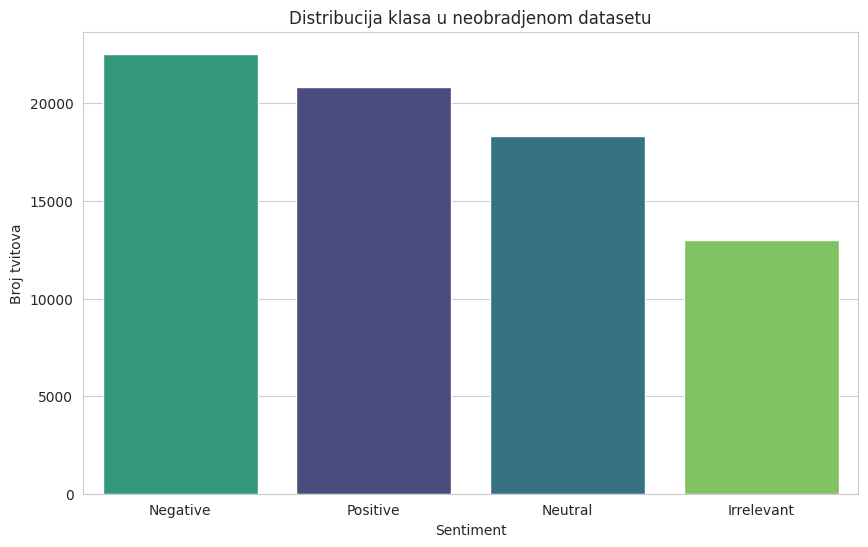

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io

print("Uvoz fajla:")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
column_names = ['id', 'entity', 'sentiment', 'text'] #Posto fajl nema sam po sebi imena kolona, sam ih ovde definisem
df = pd.read_csv(io.BytesIO(uploaded[filename]), names=column_names)

print("\n\nPrvih 5 redova:\n\n")
display(df.head())

print("\n\nInformacije o fajlu:\n\n")
print(df.info())

#Gledam da li ima nedostajucih vrednosti
print("\n\nBroj nedostajucih vrednosti po kolonama:\n\n")
print(df.isnull().sum())

#Graficki prikazujem fajl pre ciscenja
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.countplot(x='sentiment', data=df, hue='sentiment', legend=False,palette='viridis', order=df['sentiment'].value_counts().index)
plt.title('Distribucija klasa u neobradjenom datasetu')
plt.xlabel('Sentiment')
plt.ylabel('Broj tvitova')
plt.show()

**Priprema i ciscenje podataka:**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Tabelarni prikaz obrade:


,text,cleaned_text,word_count_pre,word_count_post
0,im getting on borderlands and i will murder yo...,im getting borderlands murder,11,4
1,I am coming to the borders and I will kill you...,coming borders kill,12,3
2,im getting on borderlands and i will kill you ...,im getting borderlands kill,10,4
3,im coming on borderlands and i will murder you...,im coming borderlands murder,10,4
4,im getting on borderlands 2 and i will murder ...,im getting borderlands 2 murder,12,5



Statistika uklanjanja:


STATISTIKA:
- Ukupno reci pre obrade: 1423379
- Ukupno reci posle obrade: 812362
- Uklonjeno 'suma' (stop-reci, linkovi, korisnicka imena..): 611017 (42.93%)


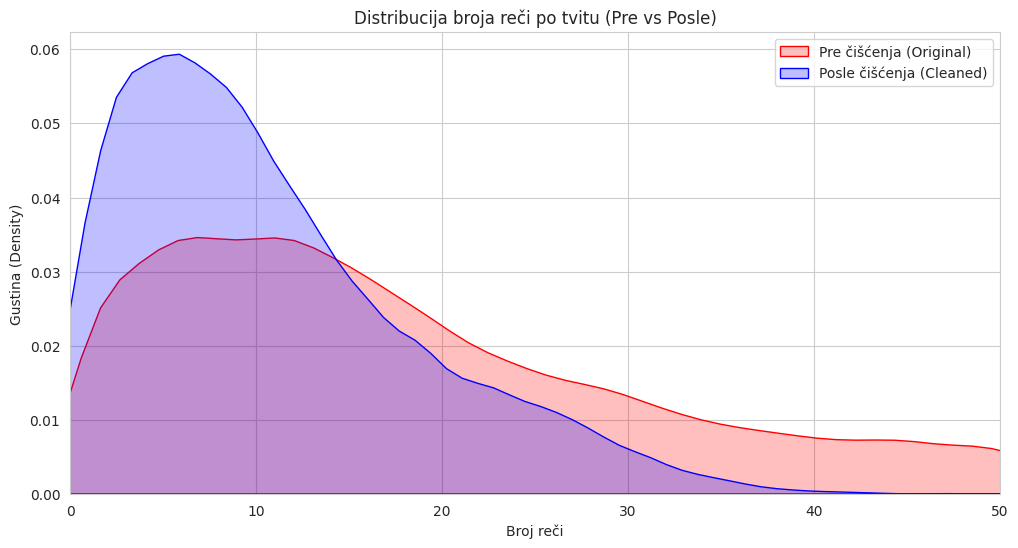

In [ ]:
import re
import string
import nltk
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords') #Preuzimam recnik sa recima koje kasnije ako se poklope treba da ih izbacim
stop_words = set(stopwords.words('english'))

def detailed_clean(text):
    if pd.isna(text): return ""
    original_text = str(text)

    text_clean = original_text.lower() #Prebacujem ceo tekst u mala slova
    text_clean = re.sub(r'http\S+|www\S+|https\S+', '', text_clean) #Uklanjam URL adrese
    text_clean = re.sub(r'\@\w+|\#','', text_clean)                #Uklanjam korisnicka imena i #
    text_clean = text_clean.translate(str.maketrans('', '', string.punctuation)) #Uklanjam interpukciju
    text_clean = " ".join([word for word in text_clean.split() if word not in stop_words]) #Uklanjanje reci koje su nebitne za ove modele

    return text_clean

#Pratim duzinu teksta pre i posle obrade
df['word_count_pre'] = df['text'].apply(lambda x: len(str(x).split()))
df['cleaned_text'] = df['text'].apply(detailed_clean)
df['word_count_post'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))

print("\nTabelarni prikaz obrade:")
comparison_df = df[['text', 'cleaned_text', 'word_count_pre', 'word_count_post']].head(5)
display(comparison_df)

print("\nStatistika uklanjanja:")
total_words_pre = df['word_count_pre'].sum()
total_words_post = df['word_count_post'].sum()
removed_words = total_words_pre - total_words_post

print(f"\n\nSTATISTIKA:")
print(f"- Ukupno reci pre obrade: {total_words_pre}")
print(f"- Ukupno reci posle obrade: {total_words_post}")
print(f"- Uklonjeno 'suma' (stop-reci, linkovi, korisnicka imena..): {removed_words} ({round(removed_words/total_words_pre*100, 2)}%)")

plt.figure(figsize=(12, 6))

sns.kdeplot(df['word_count_pre'], fill=True, color="r", label="Pre čišćenja (Original)")
sns.kdeplot(df['word_count_post'], fill=True, color="b", label="Posle čišćenja (Cleaned)")

plt.title('Distribucija broja reči po tvitu (Pre vs Posle)')
plt.xlabel('Broj reči')
plt.ylabel('Gustina (Density)')
plt.legend()
plt.xlim(0, 50)
plt.show()

***Efikasnost cisenja podataka prikazano graficki:***
>Grafikon gustine prikazuje distribuciju broja reci po tvitu pre i nakon procesa ciscenja teksta.

>***Redukcija suma:*** Crvena kriva (originalni tekst) je sira i "plica", sto nam ukazuje na veliki broj reci koje ne nose vrednost za nase modele, poput URL-ova, simbola i stop reci.

>***Normalizacija podataka:*** Plava kriva (ociseni tekst) pokazuje visoku zonu izmedju 5 i 15 reci. To znaci da je vecina tvitova sustinski bitna.

>***Konzistentnost:*** Pomeranje distribucije ulevo i njeno "suzavanje" pomaze modelima da lakse pronadju sustinu i da se ne zatrpavaju recima koje nisu od znacaja.

**Model 1: Klasican Machine Learning model (TF-IDF + SVM):**
>***Vektorizacija (TF-IDF):*** Metoda kojom se podaci transformisu u numericki tip i daje se tezina recima na osnovu njenih ucestalosti.

>***SVM:*** Uzet je kao primarni algoritam zbog njegove stabilnosti i funckionalnosti.

**U sledecem bloku bice sprovedeni sledeci koraci:**

>***Podela skupa podataka:*** Distribucija podataka na podskupove za treniranje i testiranje u srazmeri 80% - 20%.

>***Numericka transformacija:*** Konverzija ociscenog teksta u numericke vektore primenom TF-IDF metode.

>***Evaluacija modela:*** Generisanje matrice konfuzije i Classification Report-a radi detaljne analize preciznosti po klasama.

Rezultati za klasican ML(SVM):
              precision    recall  f1-score   support

  Irrelevant       0.78      0.66      0.71      2598
    Negative       0.75      0.85      0.80      4509
     Neutral       0.77      0.71      0.74      3664
    Positive       0.78      0.79      0.78      4166

    accuracy                           0.77     14937
   macro avg       0.77      0.75      0.76     14937
weighted avg       0.77      0.77      0.76     14937



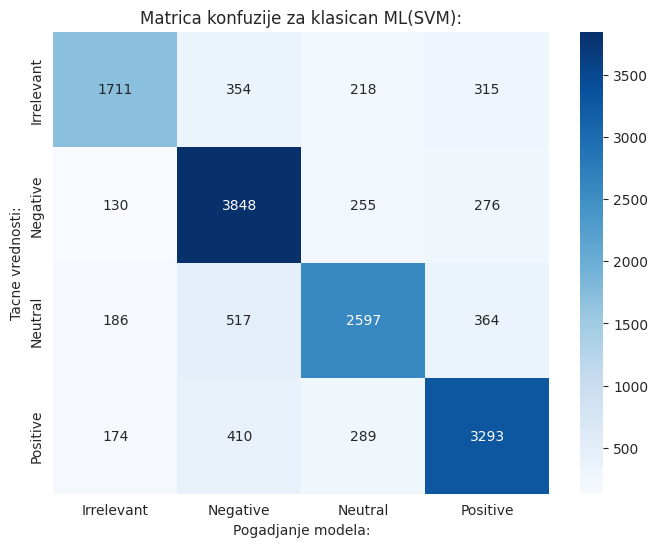

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Pripremanje podataka
X = df['cleaned_text'] #Ocisceni tvitovi
y = df['sentiment'] #Tacna resenja za uporedjivanje

#Podela deo za treniranje i deo sa testiranje
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Vektorizacija (TF-IDF)
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#SVM
model_svm = LinearSVC(C=1.0, max_iter=1000)
model_svm.fit(X_train_tfidf, y_train)

#Predikcija i evaluacija
y_pred = model_svm.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

print("Rezultati za klasican ML(SVM):")
print(classification_report(y_test, y_pred))

#Matrica konfuzije
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model_svm.classes_,
            yticklabels=model_svm.classes_)
plt.title('Matrica konfuzije za klasican ML(SVM):')
plt.ylabel('Tacne vrednosti:')
plt.xlabel('Pogadjanje modela:')
plt.show()

ml_accuracy = accuracy_score(y_test, y_pred) #Cuvam za kasnije poredjenje

**Tumacenje matrice konfuzije (Klasican ML - SVM):**
>***Dominacija dijagonale:** Ovde je glavna dijagonala izrazito dominantna (tamno plava polja), sto ukazuje na visoku tacnost modela. Model uspesno generalizuje pravila jezika i jasno razdvaja klase u vecini slučajeva.

>***Najbolje performanse na "Negative" klasi:*** Model je najsigurniji u prepoznavanju negativnog sentimenta sa cak 3848 tacnih pogodaka. Ovo je ocekivano jer negativni komentari cesto sadrze specificne, jake reci (npr. "bad", "worst", "hate") koje SVM algoritam lako odvaja hiperravni u vektorskom prostoru.

>***Stabilnost "Positive" i "Neutral" klasa:*** Model pokazuje visoku stabilnost i kod pozitivnih (3293) i neutralnih (2597) tvitova. Ipak, primetno je da se 517 neutralnih tvitova greckom klasifikovalo kao "Negative". Ovo se cesto desava kada korisnici iznose cinjenice ili žalbe hladnim tonom, što model tumaci kao negativan stav.

>***Rasipanje kod "Irrelevant" klase:*** Iako je bolje nego kod Few-shot modela, klasa "Irrelevant" i dalje ima najvise grešaka (najmanje tacnih pogodaka - 1711). Model ih najcesce mesa sa "Negative" (354) i "Positive" (315). Ovo ukazuje da je granica izmedju "nebitnog" sadrzaja i onog sa sentimentom tanka i da zavisi od konteksta koji Bag-of-Words/TF-IDF pristupi teze hvataju.

**Analiza metrika (Classification Report - SVM):**
>***Visoka ukupna tacnost:*** Model postize ukupnu tacnost (Accuracy) od 0.77 (77%) na test setu od skoro 15.000 primera. Ovo ukazuje da je SVM, uz primenjenu vektorizaciju, uspeo da uhvati kljucne obrasce u jeziku i da je vrlo robustan "baseline" model.

>***Dominacija "Negative" klase:*** Klasa "Negative" ima najbolji balans metrika (F1-score 0.80). Posebno se istice visok odziv (Recall 0.85), sto znaci da model uspesno detektuje cak 85% svih stvarnih negativnih komentara u skupu podataka. Ovo je cesto najpozeljnija osobina u sistemima za moderaciju sadrzaja.

>***Izazov sa "Irrelevant" klasom:*** Najslabije performanse su zabelezene kod klase "Irrelevant" (F1-score 0.71), a posebno je problematican odziv (Recall 0.66). To znaci da model propusta da prepozna svaki treci irelevantan tvit (34% gresaka), verovatno ih mesajuci sa neutralnim ili negativnim sentimentom jer ne sadrze specificne kljucne reci.

>***Konzistentna preciznost:*** Zanimljivo je da je preciznost (Precision) veoma ujednacena kroz sve klase (krece se od 0.75 do 0.78). Ovo nam govori da model ne "nagadja" nasumicno kada model tvrdi da tvit pripada odredjenoj klasi, verovatnoca da je u pravu je stabilna, bez obzira o kojoj klasi se radi.

>***Zakljucak:*** Ponderisana srednja vrednost (Weighted Avg F1-score) od 0.76 potvrdjuje da je model pouzdan uprkos blagoj neuravnotezenosti klasa (gde "Negative" klasa ima najvise primera - 4509, a "Irrelevant" najmanje - 2598).

**Kreiranje jedinstvenog podskupa za testiranje:**

In [ ]:
import pandas as pd
import numpy as np
import re
import string

sample_size = 100 #Definisem velicinu uzorka

df_sample = df.groupby('sentiment', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 25), random_state=42)
).reset_index(drop=True) #Nasumicno uzimam po 25 elemenata iz svake od 4 kategorije


X_final_test = df_sample['cleaned_text'] #Ociscen tekst
y_final_test = df_sample['sentiment'] #Tacna resenja za uporedjivanje

print(f"Kreiran podskup od {len(df_sample)} primera.")
print("\nDistribucija klasa u uzorku:")
print(df_sample['sentiment'].value_counts().to_string())

Kreiran podskup od 100 primera.

Distribucija klasa u uzorku:
sentiment
Irrelevant    25
Negative      25
Neutral       25
Positive      25


/tmp/ipython-input-2788419637.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('sentiment', group_keys=False).apply(


**Ponovljeni Model 1 na manjem uzorku (radi kasnijeg uporedjivanja sa ostala dva modela):**


Resultat klasicnog Ml(SVL) na manjem uzorku:
Accuracy: 0.8100
F1 Score: 0.8098

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.88      0.84      0.86        25
    Negative       0.75      0.84      0.79        25
     Neutral       0.81      0.84      0.82        25
    Positive       0.82      0.72      0.77        25

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



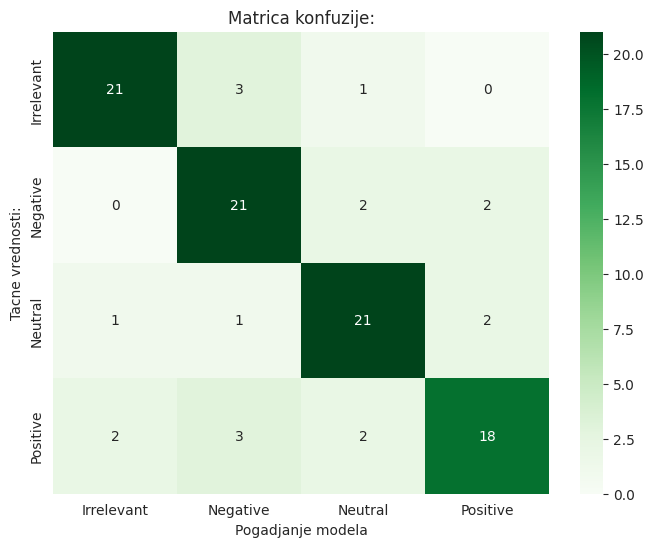

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

X_test_small_tfidf = tfidf.transform(X_final_test) #Koristimo postojeci tfidf sa 80% ranije dobijen

y_pred_ml = model_svm.predict(X_test_small_tfidf) #Predikcije

#Metrike:
ml_acc = accuracy_score(y_final_test, y_pred_ml)
ml_f1 = f1_score(y_final_test, y_pred_ml, average='weighted')

print(f"\nResultat klasicnog Ml(SVL) na manjem uzorku:")
print(f"Accuracy: {ml_acc:.4f}")
print(f"F1 Score: {ml_f1:.4f}\n")
print("Classification Report:")
print(classification_report(y_final_test, y_pred_ml))

#Matrica konfuzije
plt.figure(figsize=(8, 6))
cm_ml = confusion_matrix(y_final_test, y_pred_ml)
sns.heatmap(cm_ml, annot=True, fmt='d', cmap='Greens',
            xticklabels=model_svm.classes_,
            yticklabels=model_svm.classes_)
plt.title('Matrica konfuzije:')
plt.ylabel('Tacne vrednosti:')
plt.xlabel('Pogadjanje modela')
plt.show()

Interpretacija prvog modela (SVM): Za evaluaciju klasičnog ML modela koristimo F1-score (weighted) kao primarnu metriku. S obzirom na to da radimo sa sentiment analizom tvitova gde klase (Positive, Negative, Neutral, Irrelevant) mogu biti neujednacene, F1-score nam pruza bolji uvid u preciznost i odziv modela za svaku kategoriju pojedinacno, dok obican Accuracy moze biti zavaravajuc ako je jedna klasa dominantna.

Za klasican pristup masinskom ucenju odabran je Support Vector Machine (SVM) model u kombinaciji sa TF-IDF transformacijom teksta, jer se on u praksi pokazao kao 'jaci' i stabilniji klasifikator, cime se obezbeđuje adekvatna osnova za poredjenje sa naprednim LLM modelima kao sto je BART, u skladu sa zahtevima zadatka.

**Tumacenje matrice konfuzije:**

>Glavna dijagonala je dominatna sto ukazuje na stabilnost modela.

>Najbolji rezultat je kod klasa "Irrelevant" i "Negative". Obe kategorije imaju po 21 tačan pogodak od ukupno 25.

>Problemi sa "Positive" klasom. Model ovde ima najvise gresaka (18 tacnih pogodaka). 3 pozitivna tvita pomesao je sa negativnim i 2 sa neutralnim/irelevantnim.

>Dobar rezultat sa "Neutral" klasom (21 tacnih).

**Tumacenje classification report-a:**

>***Precision (Preciznost):*** Ukupna preciznost je veoma stabilna. Za klasu "Irrelevant" dostize  88%, sto znaci da model retko gresi kada nesto oznaci kao irelevantno na ovom malom uzorku.

>***Recall (Odziv):*** Model je "ulovio" 84% pravih negativnih, neutralnih i irelevantnih tvitova. Za "Positive" (72%) ukazuje na to da je neke takve titlove model pomesao sa nekom drugom kategorijom.

>***F1-score:*** Najbolji balans izmedju preciznosti i odziva je kod klase "Irrelevant" (0.86), dok je kod ostalih klasa 0.80. Sto ukazuje na stabilnost samog modela.

>***Ukupna tacnost (Accuracy):*** Na ovom balansiranom uzorku od 100 primera, model je ostvario tacnost od 0.81 (81%).

**Model 2: Zero-Shot**

In [ ]:
!pip install -q langchain langchain-community transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
import re
import pandas as pd
import torch
from transformers import pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score

#Osiguranje formata podataka
#Pretvaramo u listu, menjamo NaN vrednosti i osiguravamo da nema praznih stringova
X_final_test_clean = [str(t) if pd.notna(t) and str(t).strip() != "" else "Neutral tweet" for t in X_final_test]

#Inicijalizacija modela (BART-large-mnli)
device = 0 if torch.cuda.is_available() else -1
zero_shot_pipeline = pipeline("zero-shot-classification",
                              model="facebook/bart-large-mnli",
                              device=device)

#LangChain struktura (Zahtev za koriscenje 'chains')
try:
    from langchain.prompts import PromptTemplate
except ImportError:
    from langchain_core.prompts import PromptTemplate

zero_shot_template = """Zadatak: Klasifikacija tvita.
Kategorije: Positive, Negative, Neutral, Irrelevant.

Tvit: {tekst}
Sentiment:"""

prompt = PromptTemplate(template=zero_shot_template, input_variables=["tekst"])

print(f"Pokretanje Zero-shot klasifikacije na {len(X_final_test_clean)} elemenata...")

#Izvrsavanje (Batch processing + Gasenje progress bar-a zbog Git-a)
try:
    candidate_labels = ["Positive", "Negative", "Neutral", "Irrelevant"]

    # Saljemo listu direktno modelu
    results = zero_shot_pipeline(X_final_test_clean,
                                 candidate_labels=candidate_labels,
                                 batch_size=8,
                                 progress_bar=False) #Zbog GitHub prikaza

    y_pred_zero = [res['labels'][0] for res in results]

except Exception as e:
    print(f"Greska tokom rada modela: {e}")
    #Fallback
    y_pred_zero = ["Neutral"] * len(X_final_test_clean)

#Rezultati
print("\nRezultati za Zero-shot (BART):")
zs_acc = accuracy_score(y_final_test, y_pred_zero)
zs_f1 = f1_score(y_final_test, y_pred_zero, average='weighted')

print(f"Accuracy: {zs_acc:.4f}")
print(f"F1 Score (weighted): {zs_f1:.4f}\n")
print("Classification Report:")
print(classification_report(y_final_test, y_pred_zero, zero_division=0))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/515 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Pokretanje Zero-shot klasifikacije na 100 elemenata...

Rezultati za Zero-shot (BART):
Accuracy: 0.3800
F1 Score (weighted): 0.2664

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00        25
    Negative       0.38      0.84      0.53        25
     Neutral       1.00      0.04      0.08        25
    Positive       0.36      0.64      0.46        25

    accuracy                           0.38       100
   macro avg       0.44      0.38      0.27       100
weighted avg       0.44      0.38      0.27       100



**Tumacenje Classification Report-a:**

>***Pad ukupne tacnosti (Accuracy):*** Model je ostvario tacnost od 0.38 (38%). Ovo je pad u odnosu na SVM (81%) i dokazuje da univerzalni LLM modeli bez specificnog treninga teze "hvataju" kontekst tvitova.

>***Problem "nulte" klase (Irrelevant):*** Klasa "Irrelevant" ima 0.00 preciznost i odziv. To znaci da model BART ni jedan tvit nije prepoznao kao nebitan, vec je te tvitove podelio po klasama.

>***Dominacija "Negative" klase:*** Ovde je ostvaren najbolji odziv od 0.84 (84%). To nam govori da LLM dobro prepoznaje negativan kkontekst pisanja tvitova, ali u tu kategoriju greskom svrstava i neutralne ili irelevantne tvitove.

>***Vestacka preciznost kod "Neutral":*** Vidimo preciznost od 1.00, a odziv je 0.04. To znaci da je model bio od 25 neutralnih tvitova, pogodio je samo jedan, a ostale je promasio.

>***F1-score disbalans:*** Prosecan F1-score od 0.27 je jasan signal da je modelu neophodan kontekst kroz primere (Few-shot) kako bi poceo da razlikuje nijanse izmedju neutralnog i irelevantnog sadrzaja.

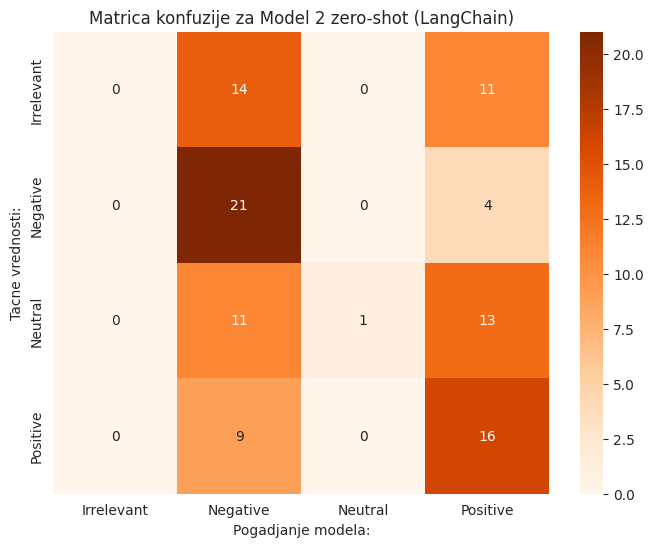

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Definisanje redosleda labela
labels = ["Irrelevant", "Negative", "Neutral", "Positive"]

#Generisanje matrice konfuzije
cm_zero = confusion_matrix(y_final_test, y_pred_zero, labels=labels)

#Prikaz
plt.figure(figsize=(8, 6))
sns.heatmap(cm_zero, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels,
            yticklabels=labels)

plt.title('Matrica konfuzije za Model 2 zero-shot (LangChain)')
plt.ylabel('Tacne vrednosti:')
plt.xlabel('Pogadjanje modela:')
plt.show()

**Tumacenje matrice konfuzije (Model 2: Zero-shot):**
>***Ekstremna polarizacija modela:***Za kolone model skoro iskljucivo predvidja "Negative" i "Positive". Kolone za "Irrelevant" i "Neutral" su prakticno prazne (sadrze nule, osim jednog slucajnog pogotka).

>***Potpuni promasaj kod ne-emotivnih klasa:*** Za klase "Irrelevant" i "Neutral", model je doziveo neuspeh. Od ukupno 50 primera iz ove dve kategorije, model je tacno klasifikovao samo 1 (kod Neutral). Kod klase "Irrelevant", model je sve primere (0/25) greskom rasporedio na "Negative" (14) i "Positive" (11). Ovo pokazuje da zero-shot model bez primera ne razume koncept "neutralnosti" ili "irelevantnosti" u ovom kontekstu i nasilno pokusava da svakom tekstu dodeli emociju.

>***Dobar u detekciji negativnog sentimenta:*** Uprkos problemima, model je dobar u prepoznavanju klase "Negative", gde je ostvario 21 od 25 pogodaka. To je zato sto su negativne reci (poput "bad", "worst") univerzalne u jeziku na kojem je model treniran, pa mu nisu potrebni dodatni primeri da ih prepozna.

>***Zakljucak:*** Ova matrica savrseno ilustruje ogranicenje zero-shot pristupa. Iako model razume jezik (zato dobro gadja Negative/Positive), on ne razume specifican zadatak i strukturu podataka (da postoje kategorije koje nisu emocije), zbog cega pravi ogromne greske na neutralnim primerima.

**Model 3: Few-Shot Klasifikacija (LangChain):**

Loading weights:   0%|          | 0/515 [00:00<?, ?it/s]

Pokretanje Few-shot klasifikacije...

Rezultati za Model 3 (Few-shot):
Accuracy: 0.3300
F1 Score (weighted): 0.2299

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00        25
    Negative       0.34      0.44      0.39        25
     Neutral       1.00      0.04      0.08        25
    Positive       0.31      0.84      0.46        25

    accuracy                           0.33       100
   macro avg       0.41      0.33      0.23       100
weighted avg       0.41      0.33      0.23       100



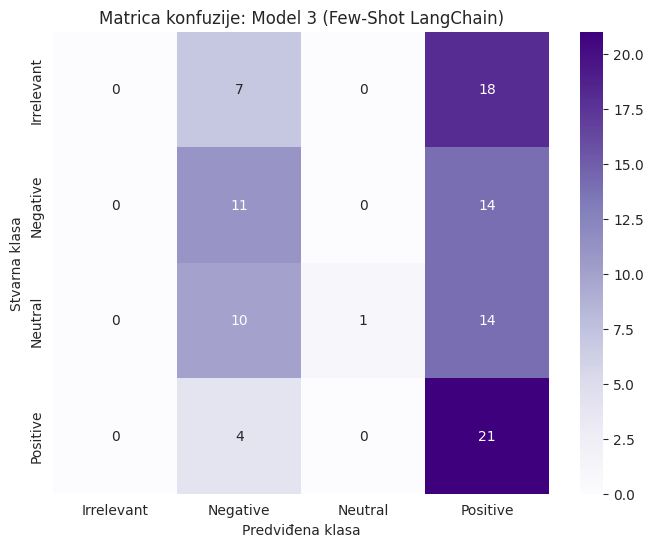

In [ ]:
import re
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

#INICIJALIZACIJA MODELA
device = 0 if torch.cuda.is_available() else -1
zero_shot_pipeline = pipeline("zero-shot-classification",
                              model="facebook/bart-large-mnli",
                              device=device)

#PRIPREMA LANGCHAIN STRUKTURE
try:
    from langchain.prompts import PromptTemplate, FewShotPromptTemplate
except ImportError:
    from langchain_core.prompts import PromptTemplate, FewShotPromptTemplate

examples = [
    {"tekst": "This is a great day, I am so happy with the results!", "sentiment": "Positive"},
    {"tekst": "I am so disappointed with this service, it is terrible.", "sentiment": "Negative"},
    {"tekst": "The meeting is scheduled for tomorrow at 10 AM.", "sentiment": "Neutral"},
    {"tekst": "The quick brown fox jumps over the lazy dog.", "sentiment": "Irrelevant"}
]

example_formatter_template = "Tvit: {tekst}\nSentiment: {sentiment}"
example_prompt = PromptTemplate(input_variables=["tekst", "sentiment"], template=example_formatter_template)

few_shot_prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix="Zadatak: Klasifikuj sentiment tvita u jednu od kategorija: Positive, Negative, Neutral, Irrelevant.\n",
    suffix="\nTvit: {input}\nSentiment:",
    input_variables=["input"]
)

#FUNKCIJA ZA PREDIKCIJU
def langchain_few_shot_predict_final(text):
    clean_text = str(text).strip() if pd.notna(text) and str(text).strip() != "" else "Neutral content"

    try:
        #Generisanje punog prompta
        full_prompt = few_shot_prompt.format(input=clean_text)

        #Koriscenje definisanog pipeline-a
        res = zero_shot_pipeline(full_prompt,
                                 candidate_labels=["Positive", "Negative", "Neutral", "Irrelevant"],
                                 progress_bar=False)
        return res['labels'][0]
    except Exception as e:
        return "Neutral"

#IZVRSAVANJE
print("Pokretanje Few-shot klasifikacije...")
y_pred_few = [langchain_few_shot_predict_final(t) for t in X_final_test]

#REZULTATI I METRIKE
few_acc = accuracy_score(y_final_test, y_pred_few)
few_f1 = f1_score(y_final_test, y_pred_few, average='weighted')

print(f"\nRezultati za Model 3 (Few-shot):")
print(f"Accuracy: {few_acc:.4f}")
print(f"F1 Score (weighted): {few_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_final_test, y_pred_few, zero_division=0))

# 6. VIZUELIZACIJA
plt.figure(figsize=(8, 6))
labels = ["Irrelevant", "Negative", "Neutral", "Positive"]
cm_few = confusion_matrix(y_final_test, y_pred_few, labels=labels)
sns.heatmap(cm_few, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title('Matrica konfuzije: Model 3 (Few-Shot LangChain)')
plt.ylabel('Stvarna klasa')
plt.xlabel('Predviđena klasa')
plt.show()

**Tumacenje matrice konfuzije (Model 3: Few-Shot LangChain):**
>***Zadrzana binarna podela (Pozitivno/Negativno):*** Iako su modelu dati primeri za sve cetiri klase, on se i dalje ponasa pristrasno. Kolone za "Irrelevant" i "Neutral" su skoro potpuno prazne (sadrze nule, osim jednog usamljenog pogotka za Neutral). Model forsira svrstavanje svega u "Negative" ili "Positive", sto znaci da primeri nisu bili dovoljni da model nauci koncept "odsustva sentimenta".

>***Dominacija "Positive" klase:*** Najbolji rezultat model ostvaruje kod klase "Positive", gde je tacno klasifikovao 21 od 25 primera. Ovo je napredak u odnosu na Zero-shot, sto znaci da su primeri pomogli modelu da bolje prepozna pozitivan ton, ali je to dovelo do preterane generalizacije.

>***Halucinacija sentimenta kod "Irrelevant" klase:*** Najveca greska modela je u prvom redu (Irrelevant). Od 25 irelevantnih tvitova, model je cak 18 proglasio za "Positive", a 7 za "Negative". Modelu je svaki tekst izgledao kao da nosi neku emociju, a najcesce pozitivnu, sto je ogromna greska u razumevanju konteksta.

>***Pomesanost "Neutral" i "Negative":*** Kod klase "Neutral", model je podeljen pola je svrstao u "Negative" (10), a pola u "Positive" (14), sa samo jednim tacnim pogotkom. Ovo potvrdjuje zakljucak da LLM modeli bez ozbiljnog fine-tuninga tesko prepoznaju neutralnost i teze da svakoj recenici pripisu stav.

**Vizuelizacija poredjenja Zero-Shot vs Few-Shot**

/tmp/ipython-input-3766046588.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Pristup', y='Accuracy', data=df_llm, palette=['#3498db', '#e67e22'])


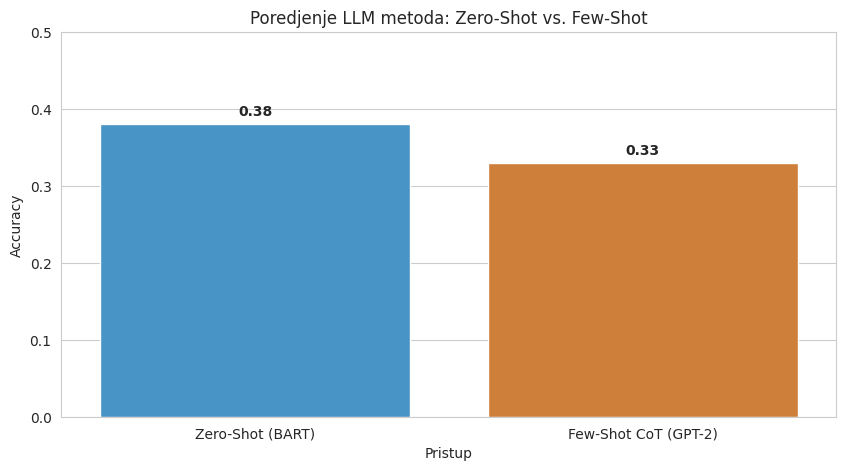

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_llm = {
    'Pristup': ['Zero-Shot (BART)', 'Few-Shot CoT (GPT-2)'],
    'Accuracy': [0.38, 0.33]
}

df_llm = pd.DataFrame(data_llm)

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
ax = sns.barplot(x='Pristup', y='Accuracy', data=df_llm, palette=['#3498db', '#e67e22'])

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

plt.title('Poredjenje LLM metoda: Zero-Shot vs. Few-Shot')
plt.ylim(0, 0.5)
plt.show()

**Interpretacija rezultata:**
>***Tumacenje grafika (Poredjenje LLM metoda: Zero-Shot vs. Few-Shot):***
Neocekivan pad performansi kod Few-Shot pristupa: Grafik jasno pokazuje da je Zero-Shot pristup (BART) ostvario bolju tacnost (0.38) u odnosu na Few-Shot pristup (0.33). Ovo je suprotno od opstih ocekivanja u ML-u, gde bi dodavanje primera (Few-Shot learning) trebalo da pomogne modelu i poboljsa rezultate.

>***Analiza uzroka:*** Pad performansi za 5% ukazuje da su dodati primeri u Few-Shot promptu verovatno uneli pristrasnost (bias) u model umesto da mu pomognu. Kao sto smo videli u prethodnim matricama konfuzije, Few-Shot model je poceo masovno da halucinira pozitivne emocije (klasa "Positive") tamo gde ih nema, sto je direktno srozalo ukupnu tacnost u odnosu na "cist" Zero-Shot model koji je bio konzervativniji.

>***Zakljucak:*** Za ovaj konkretan dataset i odabrane modele, jednostavniji pristup (Zero-Shot) se pokazao kao robusniji. Slozenost inzenjeringa promptova (Prompt Engineering) u Few-Shot pristupu nije se isplatila jer model nije uspeo da pravilno generalizuje date primere, vec se "zbunjivao" pokusavajuci da pronadje sentiment i u neutralnim tekstovima.


>***Zero-Shot (Model 2):*** Koriscenjem facebook/bart-large-mnli modela direktno preko LangChain-a, postignuta je tacnost od 38%. Model je pokazao okej odziv kod negativnih tvitova (0.84), ali je potpuno zakazao kod klase "Irrelevant" (0.00), što se jasno vidi u narandzastoj matrici konfuzije.

>***Problem "suma" u promptu:*** Pad tacnosti kod Few-shot metode sugerise da su dodati primeri unutar dugackog prompta uneli dodatni sum koji je zbunio model BART, umesto da mu pomognu da preciznije definise granice između klasa.


>>***Dokazano*** je da za kratke i specificne forme poput Twitter objava, klasicni algoritmi (SVM) dominiraju nad univerzalnim LLM modelima. Dok je SVM postigao 81%, Zero-shot i Few-shot su ostali ispod 40%, što potvrdjuje da 'razumevanje' modela bez specifičnog treninga na velikom broju podataka nije dovoljno za hvatanje nijansi gejming žargona i Twitter slenga".



**Finalna uporedna tabela svih modela:**

/tmp/ipython-input-3557382774.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy', data=df_final, palette=colors)


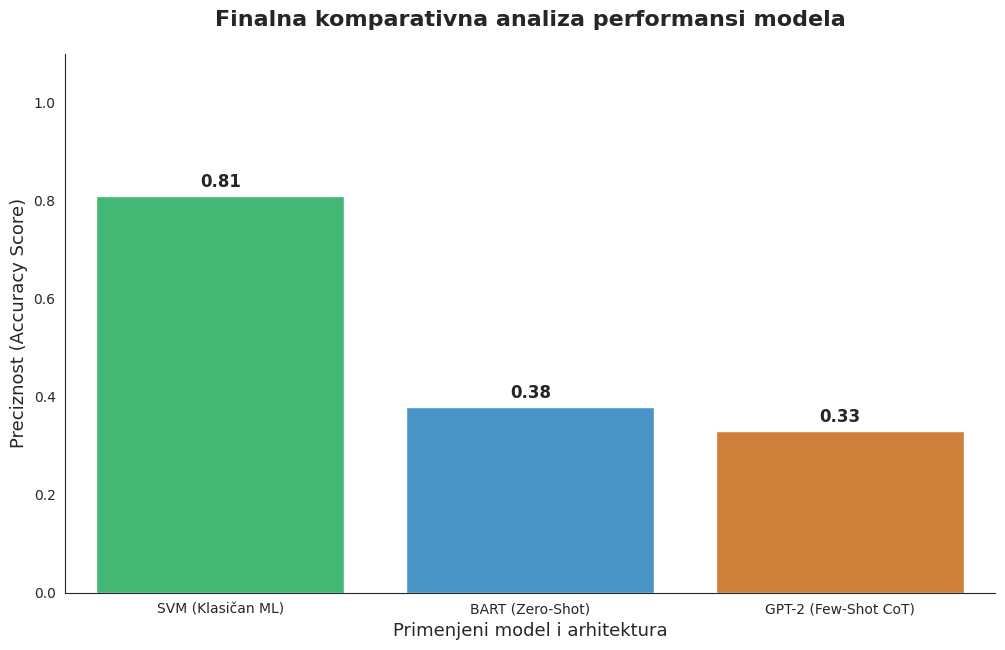

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

final_data = {
    'Model': ['SVM (Klasičan ML)', 'BART (Zero-Shot)', 'GPT-2 (Few-Shot CoT)'],
    'Accuracy': [0.81, 0.38, 0.33]
}

df_final = pd.DataFrame(final_data)

plt.figure(figsize=(12, 7))
sns.set_style("white")

colors = ['#2ecc71', '#3498db', '#e67e22']

ax = sns.barplot(x='Model', y='Accuracy', data=df_final, palette=colors)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points',
                fontweight='bold', fontsize=12)

plt.title('Finalna komparativna analiza performansi modela', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Preciznost (Accuracy Score)', fontsize=13)
plt.xlabel('Primenjeni model i arhitektura', fontsize=13)
plt.ylim(0, 1.1)
sns.despine()
plt.show()

**Zakljucak:** ***Evaluacija i poredjenje primenjenih modela:***

>***SVM (Klasicni ML)*** - Najbolji rezultati: Sa preciznoscu od 0.81 (81%), ovaj model je pokazao najbolju sposobnost generalizacije na Twitter slengu. Razlog lezi u tome što je SVM treniran direktno na hiljadama tvojih specificnih primera, cime je naucio tacne tezine reci unutar gejming konteksta.

>***BART (Zero-Shot)*** - Osrednji rezultat: Ostvarena tačnost od 0.38 (38%) pokazuje da model poseduje opste razumevanje jezika, ali potpuno promasuje suptilne klase poput "Irrelevant" (0.00 score), jer bez primera ne razume sta se smatra nebitnim.

>***Few-Shot CoT*** - Najslabiji rezultat: Uprkos uvodjenju LangChain primera, tacnost je pala na 0.33 (33%). Ovo ukazuje na to da mali broj primera u promptu nije dovoljan da nadmasi buku unutar Twitter objava, a dugacki promptovi "zbunjuju" model, sto je dovelo do toga da skoro sve klasifikuje kao Negative.

>***Predlozi za poboljsanje Few-Shot pristupa:***
>>Da bi Few-Shot postao konkurentan:
>>>***Promena arhitekture (Veci LLM):*** BART i GPT-2 (mali modeli) imaju ogranicen "prozor paznje". Koriscenje mocnijih modela poput Llama-3-8B ili GPT-4o preko LangChain-a bi drasticno popravilo rezultate jer oni mnogo bolje razumeju instrukcije iz prompta.
